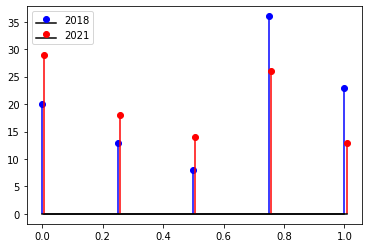

,2018,2021,change,change%,polmax,pols_min,polunif
bipol,6.489000e-01,6.472000e-01,↘,-0.3%,1.000000e+00,0.009803,6.000000e-01
variance,5.314750e-01,5.156000e-01,↘,-3.0%,1.000000e+00,0.002451,5.000000e-01
ER α=0.5,5.345196e+04,5.289846e+04,↘,-1.0%,1.000000e+05,777.817459,5.059644e+04
ER α=1,3.708920e+05,3.557760e+05,↘,-4.1%,1.000000e+06,10100.000000,3.200000e+05
ER α=1.6,3.958115e+06,3.602776e+06,↘,-9.0%,1.584893e+07,240376.458453,2.926752e+06
comete α=1.2 β=1.2,6.172528e-01,6.685179e-01,↗,8.3%,1.000000e+00,0.004983,6.297420e-01
comete α=2 β=1.2,5.030713e-01,6.800607e-01,↗,35.2%,1.000000e+00,0.000232,6.297420e-01
comete α=2 β=2,6.690136e-01,7.215372e-01,↗,7.9%,1.000000e+00,0.005000,7.071068e-01
comete α=2 β=3,7.491751e-01,7.590342e-01,↗,1.3%,1.000000e+00,0.023054,7.663094e-01
center-sq,5.525000e-01,5.300000e-01,↘,-4.1%,1.000000e+00,0.992574,5.000000e-01


{'bipol': 0.6489, 'variance': 0.531475, 'ER α=0.5': 53451.959105215115, 'ER α=1': 370892.0, 'ER α=1.6': 3958114.6103771236, 'comete α=1.2 β=1.2': 0.6172528185978986, 'comete α=2 β=1.2': 0.5030713477261647, 'comete α=2 β=2': 0.6690136458319279, 'comete α=2 β=3': 0.7491751481092156, 'center-sq': 0.5525, 'center-abs': 0.675}
{'bipol': 0.6472, 'variance': 0.5156, 'ER α=0.5': 52898.4617016931, 'ER α=1': 355776.0, 'ER α=1.6': 3602775.9456626805, 'comete α=1.2 β=1.2': 0.6685178883123469, 'comete α=2 β=1.2': 0.680060724707433, 'comete α=2 β=2': 0.7215371845195764, 'comete α=2 β=3': 0.7590341653945877, 'center-sq': 0.53, 'center-abs': 0.64}
{'bipol': 1.0, 'variance': 1.0, 'ER α=0.5': 100000.0, 'ER α=1': 1000000.0, 'ER α=1.6': 15848931.92461114, 'comete α=1.2 β=1.2': 1.0, 'comete α=2 β=1.2': 1.0, 'comete α=2 β=2': 1.0, 'comete α=2 β=3': 1.0000000000000002, 'center-sq': 1.0, 'center-abs': 1.0}
{'bipol': 0.009802960494069209, 'variance': 0.002450740123517302, 'ER α=0.5': 777.8174593052022, 'ER α=1

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def group_by(arr, *funcs, transform=False, equal_nan=True)->'tuple':
    """
    https://stackoverflow.com/a/77150915
    Groups by the K unique values of arr and applies some functions to each group.
    Each function is called K times with the indices of the group as input.
    If no functions are provided, returns the K unique values and the indices of each group.
    By default, the results are of length K, not len(arr) (like pandas "apply").
    Use transform=True to remap them to the input length (like pandas "transform").
    If a function returns tuples, it must return the same shape across groups
    because the outputs are casted to numpy arrays. Casting is deactivated for lists.
    """
    _, invs, cnts = np.unique(arr, return_counts=True, return_inverse=True, axis=0)
    funcs = funcs or [lambda idx: arr[idx[0]], lambda idx: list(idx)]
    idxs = np.split(np.argsort(arr), np.cumsum(cnts)[:-1])
    funcs_out = ()
    for f in funcs:
        out = [f(idx) for idx in idxs]
        if transform:
            out = [out[invs[i]] for i in range(len(arr))]
        if not out or not isinstance(out[0], list):
            out = np.array(out)
        funcs_out += (out,)
    return funcs_out


def parse_x_weights(x, weights=None):
    x = np.asarray(x)
    if weights is None:
        x, weights = np.unique(x, return_counts=True)
    else:
        _weights = np.asarray(weights)
        # merge repeated values if they exist
        x, weights = group_by(x, lambda idx: x[idx[0]], lambda idx: _weights[idx].sum())
    weights = weights / weights.sum()
    return x, weights


def metric_bipol(x, weights=None):
    x, weights = parse_x_weights(x, weights)
    mu = np.average(x, weights=weights)
    if np.all(x == mu):
        return 0
    L = x < mu
    R = ~L
    meanDiff = np.average(x[R], weights=weights[R]) - np.average(
        x[L], weights=weights[L]
    )
    return 4 * weights[L].sum() * weights[R].sum() * meanDiff


def ER_factory(alpha):
    """
    Esteban-Ray polarization:
    K * sum(pi**(1+alpha) * pj * abs(xi-xj) for xi, pi in zip(x, weights) for xj, pj in zip(x, weights))
    where K = 1 / 0.5**(1 + alpha) because K = 1 / sum_above_for(opinions=[0, 1])
    """

    def ER(x, weights=None):
        x = np.asarray(x)
        weights = np.ones_like(x) if weights is None else np.asarray(weights)

        out = np.sum(weights ** (1 + alpha) * weights[:, None] * np.abs(x[:, None] - x))
        out /= 2*((np.sum(weights)/2) ** (2 + alpha))
        return out

    return ER


def metric_var(x, weights=None):
    x, weights = parse_x_weights(x, weights)
    mu = np.average(x, weights=weights)
    return 4 * np.average((x - mu) ** 2, weights=weights)


def metric_squared(x, weights=None):
    x, weights = parse_x_weights(x, weights)
    return 4 * np.average((x - 0.5) ** 2, weights=weights)


def metric_abs(x, weights=None):
    x, weights = parse_x_weights(x, weights)
    return 2 * np.average(np.abs(x - 0.5), weights=weights)


def Comete_factory(alpha: float, beta: float):
    """
    Comete polarization function: Here "for..." means "for xi, pi in zip(x, weights)"
    (min_{y} sum(pi*alpha abs(xi-y)beta for...) / sum(pialpha for...)*(1/beta)
    """

    def metric_comete(x, weights=None):
        x, weights = parse_x_weights(x, weights)
        weights = weights**alpha
        weights = weights / weights.sum()

        def f(y: float):
            return np.average(np.abs(x - y) ** beta, weights=weights)

        low = np.min(x)
        high = np.max(x)
        precision = 1e-12
        tests_per_iter = 10
        while high - low > precision:
            lin = np.linspace(low, high, tests_per_iter)
            f_lin = [f(y) for y in lin]
            # import matplotlib.pyplot as plt;plt.stem(x, weights);plt.plot(lin, f_lin);plt.show()
            i: int = np.argmin(f_lin)
            low = lin[max(0, i - 2)]
            high = lin[min(len(lin) - 1, i + 2)]
        y_star = (low + high) / 2
        return 2*(f(y_star) ** (1 / beta))

    return metric_comete


def all_metrics(x, weights=None, er=None, comete=None):
    er = [0.5, 1, 1.6] if er is None else er
    comete = [(1.2, 1.2), (2,1.2),(2, 2), (2, 3)] if comete is None else comete

    metrics = {
        "bipol": metric_bipol,
        "variance": metric_var,
    }
    for alpha in er:
        key = f"ER α={round(alpha,3)}"
        metrics[key] = ER_factory(alpha)
    for alpha, beta in comete:
        key = f"comete α={round(alpha,3)} β={round(beta, 3)}"
        metrics[key] = Comete_factory(alpha, beta)

    metrics.update(
        {
            "center-sq": metric_squared,
            "center-abs": metric_abs,
        }
    )
    out = {name: metric(x, weights) for name, metric in metrics.items()}
    return out


opinions = [0, 0.25, 0.5, 0.75, 1]
weights_2018 = [20,13,8,36,23]
weights_2021 = [29,18,14,26,13]
weights_max = [50,0,0,0,50]
weights_min = [0,0,0,1,100]
weights_unif = [20,20,20,20,20]

weights_D3  = [ 3  ,   13      ,    69      ,    14     ,     1]
weights_D6 = [45, 25 , 16 , 10 , 4]
weights_D9 =  [3    ,      25      ,    45       ,   24      ,     3]
weights_D10 = [36    , 20    ,      27       ,   11     ,      6]
weights_D14 = [36 ,   10    ,   8   ,  11    ,   35]


plt.stem(opinions, weights_2018, 'b', markerfmt='bo', basefmt="black", label="2018")
# plt.title("2018")
# plt.show()
# plt.title("2021")
plt.stem(np.array(opinions)+0.007, weights_2021, 'r', markerfmt='ro',  basefmt="black", label="2021")
plt.legend()
plt.show()

pols_2018 = all_metrics(opinions, weights_2018)
pols_2021 = all_metrics(opinions, weights_2021)
pols_max  = all_metrics(opinions,weights_max)
pols_min = all_metrics(opinions,weights_min)
pols_unif = all_metrics(opinions,weights_unif)

pols_D3 = all_metrics(opinions,weights_D3)
pols_D6 = all_metrics(opinions,weights_D6)
pols_D9 = all_metrics(opinions,weights_D9)
pols_D10 = all_metrics(opinions,weights_D10)
pols_D14 = all_metrics(opinions,weights_D14)


symbol = lambda diff: "↗" if diff > 0 else "→" if np.isclose(diff, 0) else "↘"
change = {name: symbol(pols_2021[name] - pols_2018[name]) for name in pols_2018}
p_change = {name: f"{100*(pols_2021[name] - pols_2018[name])/pols_2018[name]:.1f}%" for name in pols_2018}

import pandas as pd

display(pd.DataFrame({"2018": pols_2018, "2021": pols_2021, "change": change, "change%": p_change, "polmax": pols_max, "pols_min": pols_min, "polunif": pols_unif}))


print(pols_2018)
print(pols_2021)
print(pols_max)
print(pols_min)
print(pols_unif)
print(pols_D3)
print(pols_D6)
print(pols_D9)
print(pols_D10)
print(pols_D14)

In [132]:
ER_factory(alpha=1)([0, 0.25, 0.5, 0.75, 1],[20,13,8,36,23])

370892.0

In [131]:
ER_factory(alpha=0.5)([0, 0.25, 0.5, 0.75, 1],[20,13,8,36,23])

53451.959105215115

In [130]:
Comete_factory(alpha=1.2, beta=1.2)([0, 0.25, 0.5, 0.75, 1],[20,13,8,36,23])

0.6172528185978986

In [30]:
parse_x_weights([50,10,10,20,10])

(array([10, 20, 50]), array([0.6, 0.2, 0.2]))

In [16]:

def Comete_factory(alpha: float, beta: float):
    """
    Comete polarization function: Here "for..." means "for xi, pi in zip(x, weights)"
    (min_{y} sum(pi*alpha abs(xi-y)beta for...) / sum(pialpha for...)*(1/beta)
    """

    def metric_comete(x, weights=None):
        x, weights = parse_x_weights(x, weights)
        weights = weights**alpha
        weights = weights / weights.sum()

        def f(y: float):
            return np.average(np.abs(x - y) ** beta, weights=weights)

        low = np.min(x)
        high = np.max(x)
        precision = 1e-12
        tests_per_iter = 10
        while high - low > precision:
            lin = np.linspace(low, high, tests_per_iter)
            f_lin = [f(y) for y in lin]
            # import matplotlib.pyplot as plt;plt.stem(x, weights);plt.plot(lin, f_lin);plt.show()
            i: int = np.argmin(f_lin)
            low = lin[max(0, i - 2)]
            high = lin[min(len(lin) - 1, i + 2)]
        y_star = (low + high) / 2
        return 2*(f(y_star) ** (1 / beta))

    return metric_comete

In [120]:
ER_factory(alpha=0.5)([0.4, 0.1,0.1,0.1,0.3])

9.050966799187808

In [ ]:
Comete_factory()